# Fine-tuning SAM on Satellite Images for Street Segmentation

Our approach is based on reusing the pretrained SAM Vision Transformer, more specifically using the image encoder and discarding the prompt encoder and mask decoder. 

Instead we will try out a combination of different Custom Encoder thats we use on the encoded images. 

We will try to use different approaches for the Decocer: 

1. Conv/Deconv based approach
2. Fully connected MLP's
3. Same as the mask decoder? 
4. Transformer, ViT? 

Another idea is to use adapter finetuning ?

Furthermore things that can be modified are how many last layers of the SAM encoder are also fine tuned? 
Possibly just finetune them, after a while of training the newly initialized decoder. 

We will work with a lr schedule that reduces on plateau.


---
### Loss function: 
We use combination of the following: 
- DiceLoss
- FocalLoss
- BCEWithLogitsLoss
---
### Learning rate:
- really small values
- reduceLROnPlateau(optimizer, 'max', patience=reduce_patience, verbose=verbose, factor=reduce_factor)
- cosine annealing


TODO: 

- IMPLEMENT LR SCHEDULE AND STOPPING CRITERIA
- CHECK OUT OTHER DECODERS SegFormer, MLP ... 
- CHECK OUT TO TRAIN MORE LAYERS OF TRANSFORMER

# Novel Ideas:

- LOOK AT VIT ARCHITECTURE
- TRAIN FROM SCRATCH, VARIE SOMETHING WITH LOCAL/GLOBAL ATTENTION or try some COMBINATION RESIDUAL/SKIP CONNECTIONS.



In [1]:
import torch
import numpy as np
import random

seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True


## Loading the dataset

In [2]:
# written by Jannek Ulm 16.5.2024
# code was inspired by the following sources: https://github.com/bnsreenu/python_for_microscopists/blob/master/331_fine_tune_SAM_mito.ipynb

from utils.image_loading import * 
from utils.torch_device import *
from custom_datasets import Sat_Mask_Dataset, Sat_Only_Image_Dataset

device = get_torch_device(allow_mps=True)
print("using device:",device)

###########

original_data = {}
original_data["images"] =load_training_images()
original_data["masks"] = load_groundtruth_images()

city_names = ["boston","nyc"]#,"zurich"]
custom_data = {"images":[],"masks":[]} # stores images and gt masks

for name in city_names:
    custom_data["images"].extend(load_training_images(name))
    custom_data["masks"].extend(load_groundtruth_images(name))

custom_data["images"] = custom_data["images"]#[0:2000]
custom_data["masks"] = custom_data["masks"]#[0:2000]

assert (len(custom_data["images"]) == len(custom_data["masks"]))


print("the raw custom dataset contains",len(custom_data["images"]),"images")

print("custom ds: (min,mean,max) street ratio",get_street_ratio_mmm(custom_data["masks"]))
print("orig ds: (min,mean,max) street ratio",get_street_ratio_mmm(original_data["masks"]))

# create a dataset
custom_data_set = Sat_Mask_Dataset(custom_data["images"], custom_data["masks"],min_street_ratio=0.03,max_street_ratio=1.0)
original_data_set = Sat_Mask_Dataset(original_data["images"],original_data["masks"])
print("after cleanup, the dataset now contains",len(custom_data_set),"images")


# submission kaggle dataset

kaggle_submission_images = load_test_images()
submission_data_set = Sat_Only_Image_Dataset(kaggle_submission_images)


/Users/janulm/miniconda3/envs/mps/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/janulm/miniconda3/envs/mps/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/janulm/miniconda3/envs/mps/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <CDAC6E34-8608-3E70-8B2F-32BCD38E90FB> /Users/janulm/miniconda3/envs/mps/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/janulm/miniconda3/envs/mps/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. S

using device: mps
the raw custom dataset contains 8367 images
custom ds: (min,mean,max) street ratio (0.0, 0.13353617634755624, 0.72180625)
orig ds: (min,mean,max) street ratio (0.008968750000000001, 0.17797695312500006, 0.40426875)
Initialzed dataset, checked for min,max street ratio. Discarded %: 0.12071232221823831  num discarded: 1010
Initialzed dataset, checked for min,max street ratio. Discarded %: 0.0  num discarded: 0
after cleanup, the dataset now contains 7357 images


In [5]:
dataset = custom_data_set
print(dataset[0][0].shape, dataset[0][0].dtype, dataset[0][0].mean(), dataset[0][0].min(), dataset[0][0].max())
print(dataset[0][1].shape, dataset[0][1].dtype, dataset[0][1].mean(), dataset[0][1].min(), dataset[0][1].max())

torch.Size([3, 1024, 1024]) torch.float32 tensor(133.7138) tensor(1.) tensor(254.)
torch.Size([1, 1024, 1024]) torch.float32 tensor(0.3802) tensor(0.) tensor(1.)


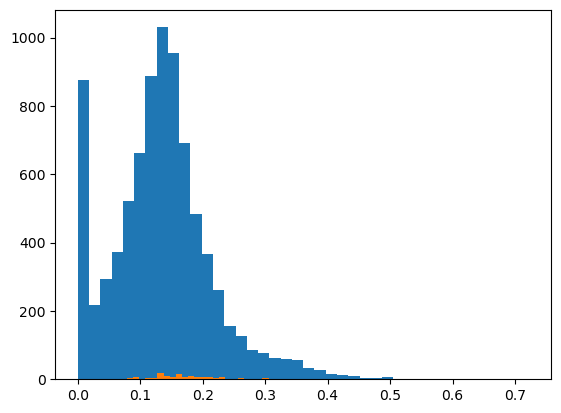

In [6]:
# plot the street ratio distribution of the dataset

custom_ratios = get_street_ratio_distr(custom_data["masks"])
original_ratios = get_street_ratio_distr(original_data["masks"])

plt.hist(custom_ratios,40)
plt.hist(original_ratios,40)
plt.show()

img:  (1024, 1024, 3) uint8 1 254 133.7029275894165
mask2:  (1024, 1024, 1) uint8 0 255
cmb:  (1024, 1024, 3) uint8 0 255 119.07334073384602


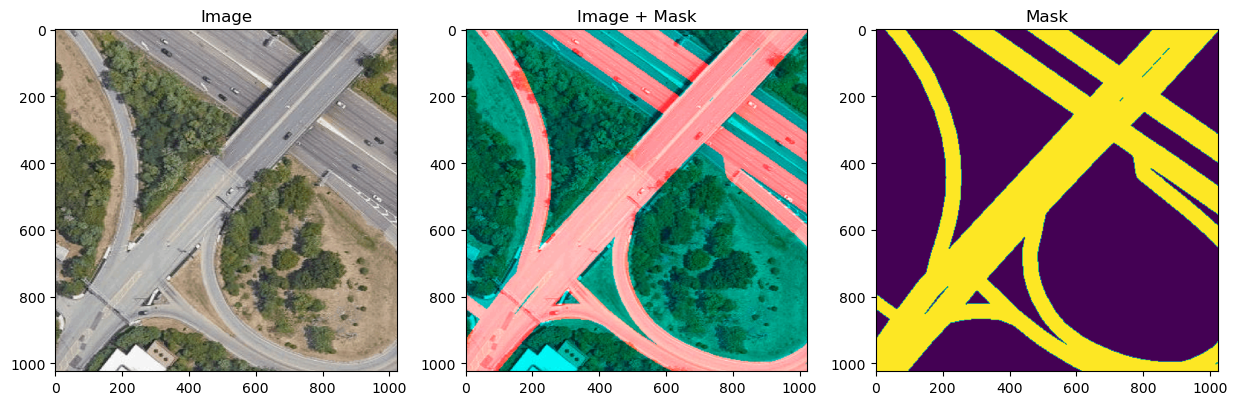

0 255 0.0 1.0


In [7]:
# make sure the dataset loading works as planned: 

import matplotlib.pyplot as plt

# get some random training images
idx = 0
image, mask = custom_data_set[idx]

img = np.array(image).astype(np.uint8)
# swap first and third dimension
img = np.swapaxes(img, 0, 2)
mask = np.array(mask)
mask = np.swapaxes(mask, 0, 2)

# 1x2 plot: 
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title("Image")
plt.imshow(img)

# image + mask overlay
plt.subplot(1, 3, 2)
plt.title("Image + Mask")
print("img: ",img.shape,img.dtype,img.min(),img.max(),img.mean())
mask2 = (mask * 255.).astype(np.uint8)
print("mask2: ",mask2.shape,mask2.dtype,mask2.min(),mask2.max())
cmb = img
cmb[:,:,0] = mask2[:,:,0]  
print("cmb: ",cmb.shape,cmb.dtype,cmb.min(),cmb.max(),cmb.mean())
plt.imshow(cmb)

# mask
plt.subplot(1, 3, 3)
plt.title("Mask")
plt.imshow(mask)
plt.show()
print(img.min(), img.max(), mask.min(), mask.max())


## Dataloader

In [8]:
train_split = 0.8
batch_size = 1


import torch.utils.data
custom_train_dataset, custom_test_dataset = torch.utils.data.random_split(custom_data_set, [train_split, 1-train_split])
original_train_dataset, original_test_dataset = torch.utils.data.random_split(original_data_set, [train_split, 1-train_split])


print(len(custom_train_dataset), len(custom_test_dataset))

from torch.utils.data import DataLoader


# CHECK IF THE FOR MULTIPLE NUM WORKERS THE CODE WORKS AS EXPECTED
# SEEMS TO BE CAUSING ISSUES WITH LONG startup and shutdown times for each epoch

# decided to drop last to make f1/loss score mean computation easier.

original_train_dataloader = DataLoader(original_train_dataset, batch_size=batch_size, shuffle=True, drop_last=True,num_workers=4,persistent_workers=True)
original_test_dataloader = DataLoader(original_test_dataset, batch_size=batch_size, shuffle=False, drop_last=True,num_workers=4,persistent_workers=True)
original_dataloader = DataLoader(original_data_set, batch_size=batch_size, shuffle=False, drop_last=True,num_workers=4,persistent_workers=True)

# dataloader for submission dataset: 
submission_dataloader = DataLoader(submission_data_set, batch_size=batch_size, shuffle=False, drop_last=False,num_workers=4,persistent_workers=True)

custom_train_dataloader = DataLoader(custom_train_dataset, batch_size=batch_size, shuffle=True, drop_last=True,num_workers=4,persistent_workers=True)
custom_test_dataloader = DataLoader(custom_test_dataset, batch_size=batch_size, shuffle=False, drop_last=True,num_workers=4,persistent_workers=True)

5886 1471


## Loading the model

In [3]:

############ (CUSTOM SAM (stored in repo))
from custom_segment_anything.segment_anything import sam_model_registry
from custom_segment_anything.segment_anything.CUSTOM_SAM import *

# load the model from checkpoints on disk:
def load_sam_decoder_model_from_checkpoint(checkpoint_idx:int, device,decoder,encoder_finetune_num_last_layers=6):
    sam_checkpoint_path = "custom_segment_anything/model_checkpoints/"
    # base, large, huge checkpoints. 
    checkpoint_names = ["vit_b","vit_l","vit_h"]
    checkpoints = ["sam_vit_b_01ec64.pth","sam_vit_l_0b3195.pth","sam_vit_h_4b8939.pth"]
    model_paths = [sam_checkpoint_path+checkpoint_name for checkpoint_name in checkpoints]
    sam = sam_model_registry[checkpoint_names[checkpoint_idx]](checkpoint=model_paths[checkpoint_idx])
    sam.to(device)
    model = SAM_Encoder_Custom_Decoder(sam.preprocess, sam.image_encoder,decoder=decoder,encoder_finetune_num_last_layers=encoder_finetune_num_last_layers)
    model = model.to(device)
    return model


# load the finetnued model state, if already started training. 
def load_finetuned_model(name,device,decoder,encoder_finetune_num_last_layers=6):
    model = load_sam_decoder_model_from_checkpoint(0,device,decoder,encoder_finetune_num_last_layers)
    finetune_path = "custom_segment_anything/model_checkpoints/finetuned/"
    model.load_state_dict(torch.load(finetune_path+name,map_location=torch.device('cpu')))
    model = model.to(device)
    return model

############################



def load_sam_model(decoder_option, device, encoder_finetune_num_last_layers, sam_checkpoint_idx=0,finetuned_model_name="model.pth",sam_checkpoint_or_finetuned="sam"):
    #   
    #   decoder_options: ["conv", "mlp" , "segformer_mlp"]
    #   encoder_finetune_num_last_layers tells how many layers of sam encoder are finetuned, all decoder layers are tuned. 
    #   sam_checkpoint_or_finetuned checks if the model is loaded from a sam checkpoint or a finetuned model with the same architecture.
    #


    # first construct the model from sam_checkpoint:

    if decoder_option == "conv":
        decoder = Conv_Decoder()
        model = load_sam_decoder_model_from_checkpoint(sam_checkpoint_idx,device,decoder.decoder,encoder_finetune_num_last_layers)
   
    elif decoder_option == "mlp":
        decoder = MLP_Decoder()
        model = load_sam_decoder_model_from_checkpoint(sam_checkpoint_idx,device,decoder,encoder_finetune_num_last_layers)

    elif decoder_option == "segformer_mlp":
        raise NotImplementedError("segformer_mlp decoder not implemented yet")
    else:
        raise ValueError("invalid decoder option")
    
    # if should load from fine-tuned model, load the model from the finetuned path.
    if sam_checkpoint_or_finetuned == "finetuned":
        finetune_path = "custom_segment_anything/model_checkpoints/finetuned/"
        model.load_state_dict(torch.load(finetune_path+finetuned_model_name,map_location=torch.device('cpu')))
    elif sam_checkpoint_or_finetuned == "sam":
        pass
        # already initialized model from sam_checkpoint
    else: 
        raise ValueError("invalid sam_checkpoint_or_finetuned option")
    
    model = model.to(device)
    return model

# Actually loading the model

In [4]:
finetuned_model_name = "model_best_so_far.pth"
model = load_sam_model("mlp",device,encoder_finetune_num_last_layers=0,sam_checkpoint_idx=0,finetuned_model_name=finetuned_model_name,sam_checkpoint_or_finetuned="sam")


print("Model loaded")
# how many trainable parameters does the model have?
print("Trainable parameters",sum(p.numel() for p in model.parameters() if p.requires_grad))
# how many total parameters does the model have?
print("Total parameters",sum(p.numel() for p in model.parameters()))

# percentage of trainable parameters
print("Percentage of trainable parameters: ")
print(sum(p.numel() for p in model.parameters() if p.requires_grad) / sum(p.numel() for p in model.parameters()))

Last layer number: 176
Model loaded
Trainable parameters 591360
Total parameters 90262272
Percentage of trainable parameters: 
0.006551574505015784


In [5]:
print(model)

SAM_Encoder_Custom_Decoder(
  (sam_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3):

In [6]:
for name, param in model.named_parameters():
    print(name, param.requires_grad)

sam_encoder.pos_embed False
sam_encoder.patch_embed.proj.weight False
sam_encoder.patch_embed.proj.bias False
sam_encoder.blocks.0.norm1.weight False
sam_encoder.blocks.0.norm1.bias False
sam_encoder.blocks.0.attn.rel_pos_h False
sam_encoder.blocks.0.attn.rel_pos_w False
sam_encoder.blocks.0.attn.qkv.weight False
sam_encoder.blocks.0.attn.qkv.bias False
sam_encoder.blocks.0.attn.proj.weight False
sam_encoder.blocks.0.attn.proj.bias False
sam_encoder.blocks.0.norm2.weight False
sam_encoder.blocks.0.norm2.bias False
sam_encoder.blocks.0.mlp.lin1.weight False
sam_encoder.blocks.0.mlp.lin1.bias False
sam_encoder.blocks.0.mlp.lin2.weight False
sam_encoder.blocks.0.mlp.lin2.bias False
sam_encoder.blocks.1.norm1.weight False
sam_encoder.blocks.1.norm1.bias False
sam_encoder.blocks.1.attn.rel_pos_h False
sam_encoder.blocks.1.attn.rel_pos_w False
sam_encoder.blocks.1.attn.qkv.weight False
sam_encoder.blocks.1.attn.qkv.bias False
sam_encoder.blocks.1.attn.proj.weight False
sam_encoder.blocks.1.a

# Loss Functions

In [10]:

from torcheval.metrics.functional import multiclass_f1_score
import torch.nn as nn
from torchvision.ops import sigmoid_focal_loss

def mean_f1_score_from_logits(pred,mask):
    # assume both inputs have the shape (batchsize,1, h,w), where h=w=1024
    # compute the mean for all the images
    # computes the mean over the 0-th axis
    pred_classes = torch.round(torch.sigmoid(pred))
    return mean_f1_score_from_classes(mask,pred_classes)


def mean_f1_score_from_classes(preds,masks):
    
    # assume both inputs have the shape (batchsize,1, h,w), where h=w=1024
    # this computes the f1 over the whole batch, for each image in the batch alone:
    
    # first reshape the tensors
    b_size = masks.shape[0]
    f1_acc = 0.
    size = torch.prod(torch.tensor(masks.shape[1:]))
    for i in range(b_size):
        mask = masks[i]
        pred = preds[i]
        # reshape and compute f1
        f1_acc = f1_acc + multiclass_f1_score(pred.reshape((size)),mask.reshape((size)))
        
    mean_f1 = f1_acc/b_size
    return mean_f1

def dice_loss(logits,masks, smooth=1e-6):
    
    probs = torch.sigmoid(logits)
    probs_flat = probs.view(-1)
    masks_flat = probs.view(-1)
    
    intersection = (probs_flat * masks_flat).sum()
    union = probs_flat.sum() + masks_flat.sum()
    dice_coeff = (2.0 * intersection + smooth) / (union + smooth)
    return 1.0 - dice_coeff


class_weights = torch.tensor([1./0.13]).to(device)  # Example weights: adjust based on your dataset
bce_loss = nn.BCEWithLogitsLoss(weight=class_weights)

def focal_loss(logits, masks, alpha=0.15, gamma=2.0):
    probs = torch.sigmoid(logits)
    loss = sigmoid_focal_loss(probs, masks, alpha=alpha, gamma=gamma, reduction='mean')
    return loss


def combined_loss(logits, masks, weighting = 0.5, alpha=0.15, gamma=2.0, smooth=1e-6):
    return  (weighting) * focal_loss(logits, masks, alpha=alpha, gamma=gamma) + (1-weighting) * dice_loss(logits, masks, smooth=smooth) # + bce_loss(logits, masks)

In [11]:
assert False

AssertionError: 

# Training Loop

In [12]:
import torch
from tqdm import tqdm
import torch.nn as nn


optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 1

if torch.cuda.is_available():
    combined_loss = torch.compile(combined_loss)
    model = torch.compile(model)

model_description = "conv_decoder_finetune_last_x_"

train_loader = custom_train_dataloader
test_loader = original_dataloader

# print interval and num_steps for gradient accumulation
num_steps_backprop = 5
print_interval = len(train_loader) // 10

# store all losses and f1 scores for the training and testing runs

losses = {"train":[],"test":[]}
f1_scores = {"train":[],"test":[]}

for epoch in range(num_epochs):
    # training run: 
    model.train()
    # store running losses for the epoch and the 10% print interval
    epoch_running_loss = 0.0
    epoch_running_f1 = 0.0

    short_running_loss = 0.0
    short_running_f1 = 0.0

    step_counter = 1
    # reset the gradients: 
    optimizer.zero_grad()
    for image, mask in tqdm(train_loader):
        # forward pass
        image = image.to(device)
        mask = mask.to(device)    
        pred = model(image)
        # compute loss and f1 score: 
        loss = combined_loss(pred,mask)
        # gradient accumulation
        loss.backward()
        # store the gradient information
        f1_score = mean_f1_score_from_logits(pred,mask).item()
        epoch_running_loss += loss.item()
        epoch_running_f1 += f1_score
        short_running_loss += loss.item()
        short_running_f1 += f1_score

        losses["train"].append(loss.item())
        f1_scores["train"].append(f1_score)

        if step_counter % num_steps_backprop == 0:
            # update the model weights
            optimizer.step()
            # reset the gradients
            optimizer.zero_grad()


        if step_counter % print_interval == 0:
            print("step: ",step_counter)
            # print out the current losses:
            print(f"Epoch: {epoch}, step: {step_counter//print_interval}, (train) Loss: {short_running_loss/print_interval}, F1: {short_running_f1/print_interval}")
            # and reset the short running losses
            short_running_loss = 0.0
            short_running_f1 = 0.0

        # increment the step counter: 
        step_counter += 1
        
    print(f"Epoch: {epoch}, (train) Loss: {epoch_running_loss/len(train_loader)}, F1: {epoch_running_f1/len(train_loader)}")

    # save the model in every epoch
    torch.save(model.state_dict(), f"custom_segment_anything/model_checkpoints/finetuned/model_{model_description}_epoch{epoch}.pth")
   
    
    # testing run: 
    model.eval()
    with torch.no_grad():
        l_acc = 0.0
        score_acc = 0.0
        for image,mask in tqdm(test_loader):
            image = image.to(device)
            mask = mask.to(device)
            pred = model(image)
            # compute loss and f1 score: 
            score = mean_f1_score_from_logits(pred,mask)    
            loss =  combined_loss(pred,mask)
            # update running loss and f1 score
            score_acc += score.item()
            l_acc  += loss.item()
            # store the loss and f1 score
            losses["test"].append(loss.item())
            f1_scores["test"].append(score.item())

        print(f"Epoch: {epoch}, (test) Loss: {l_acc/len(test_loader)}, F1-Score: {score_acc/len(test_loader)}")    
    

  0%|          | 0/5886 [00:00<?, ?it/s]/Users/janulm/miniconda3/envs/mps/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/janulm/miniconda3/envs/mps/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/janulm/miniconda3/envs/mps/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <CDAC6E34-8608-3E70-8B2F-32BCD38E90FB> /Users/janulm/miniconda3/envs/mps/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/janulm/miniconda3/envs/mps/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to

shape after encoder: torch.Size([1, 256, 64, 64])


  0%|          | 1/5886 [00:46<76:30:10, 46.80s/it]

step:  0
Epoch: 0, step: 0, (train) Loss: 0.0004457975832783446, F1: 0.0016097389921850087
shape after encoder: torch.Size([1, 256, 64, 64])


  0%|          | 2/5886 [00:47<32:12:50, 19.71s/it]

shape after encoder: torch.Size([1, 256, 64, 64])


  0%|          | 3/5886 [00:48<18:14:00, 11.16s/it]

shape after encoder: torch.Size([1, 256, 64, 64])


  0%|          | 4/5886 [00:49<11:24:44,  6.98s/it]

shape after encoder: torch.Size([1, 256, 64, 64])


  0%|          | 5/5886 [00:49<7:38:20,  4.68s/it] 

shape after encoder: torch.Size([1, 256, 64, 64])


  0%|          | 6/5886 [00:50<5:22:36,  3.29s/it]

shape after encoder: torch.Size([1, 256, 64, 64])


  0%|          | 7/5886 [00:50<3:55:57,  2.41s/it]

shape after encoder: torch.Size([1, 256, 64, 64])


  0%|          | 8/5886 [00:51<2:58:56,  1.83s/it]

shape after encoder: torch.Size([1, 256, 64, 64])


  0%|          | 9/5886 [00:52<2:20:33,  1.43s/it]

shape after encoder: torch.Size([1, 256, 64, 64])


  0%|          | 10/5886 [00:52<1:54:42,  1.17s/it]

shape after encoder: torch.Size([1, 256, 64, 64])


  0%|          | 11/5886 [00:53<1:37:59,  1.00s/it]

shape after encoder: torch.Size([1, 256, 64, 64])


  0%|          | 12/5886 [00:53<1:25:24,  1.15it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  0%|          | 13/5886 [00:54<1:16:41,  1.28it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  0%|          | 14/5886 [00:54<1:10:44,  1.38it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  0%|          | 15/5886 [00:55<1:06:39,  1.47it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  0%|          | 16/5886 [00:56<1:04:26,  1.52it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  0%|          | 17/5886 [00:56<1:02:13,  1.57it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  0%|          | 18/5886 [00:57<1:00:43,  1.61it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  0%|          | 19/5886 [00:57<59:26,  1.64it/s]  

shape after encoder: torch.Size([1, 256, 64, 64])


  0%|          | 20/5886 [00:58<58:41,  1.67it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  0%|          | 21/5886 [00:59<58:46,  1.66it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  0%|          | 22/5886 [00:59<58:02,  1.68it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  0%|          | 23/5886 [01:00<57:41,  1.69it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  0%|          | 24/5886 [01:00<57:24,  1.70it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  0%|          | 25/5886 [01:01<57:11,  1.71it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  0%|          | 26/5886 [01:02<57:47,  1.69it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  0%|          | 27/5886 [01:02<57:24,  1.70it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  0%|          | 28/5886 [01:03<57:24,  1.70it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  0%|          | 29/5886 [01:03<57:02,  1.71it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  1%|          | 30/5886 [01:04<57:14,  1.71it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  1%|          | 31/5886 [01:04<57:48,  1.69it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  1%|          | 32/5886 [01:05<57:19,  1.70it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  1%|          | 33/5886 [01:06<57:14,  1.70it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  1%|          | 34/5886 [01:06<57:06,  1.71it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  1%|          | 35/5886 [01:07<56:57,  1.71it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  1%|          | 36/5886 [01:07<57:32,  1.69it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  1%|          | 37/5886 [01:08<57:05,  1.71it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  1%|          | 38/5886 [01:09<56:54,  1.71it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  1%|          | 39/5886 [01:09<56:51,  1.71it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  1%|          | 40/5886 [01:10<56:41,  1.72it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  1%|          | 41/5886 [01:10<57:27,  1.70it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  1%|          | 42/5886 [01:11<56:58,  1.71it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  1%|          | 43/5886 [01:11<56:52,  1.71it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  1%|          | 44/5886 [01:12<56:58,  1.71it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  1%|          | 45/5886 [01:13<56:43,  1.72it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  1%|          | 46/5886 [01:13<57:25,  1.69it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  1%|          | 47/5886 [01:14<57:03,  1.71it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  1%|          | 48/5886 [01:14<56:56,  1.71it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  1%|          | 49/5886 [01:15<56:52,  1.71it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  1%|          | 50/5886 [01:16<56:41,  1.72it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  1%|          | 51/5886 [01:16<57:13,  1.70it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  1%|          | 52/5886 [01:17<56:46,  1.71it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  1%|          | 53/5886 [01:17<56:36,  1.72it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  1%|          | 54/5886 [01:18<56:36,  1.72it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  1%|          | 55/5886 [01:18<56:24,  1.72it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  1%|          | 56/5886 [01:19<57:25,  1.69it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  1%|          | 57/5886 [01:20<57:13,  1.70it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  1%|          | 58/5886 [01:20<56:55,  1.71it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  1%|          | 59/5886 [01:21<56:50,  1.71it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  1%|          | 60/5886 [01:21<56:32,  1.72it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  1%|          | 61/5886 [01:22<56:58,  1.70it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  1%|          | 62/5886 [01:23<56:46,  1.71it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  1%|          | 63/5886 [01:23<56:39,  1.71it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  1%|          | 64/5886 [01:24<56:25,  1.72it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  1%|          | 65/5886 [01:24<56:15,  1.72it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  1%|          | 66/5886 [01:25<56:47,  1.71it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  1%|          | 67/5886 [01:26<56:30,  1.72it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  1%|          | 68/5886 [01:26<56:22,  1.72it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  1%|          | 69/5886 [01:27<56:32,  1.71it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  1%|          | 70/5886 [01:27<56:29,  1.72it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  1%|          | 71/5886 [01:28<57:00,  1.70it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  1%|          | 72/5886 [01:28<56:59,  1.70it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  1%|          | 73/5886 [01:29<56:56,  1.70it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  1%|▏         | 74/5886 [01:30<56:47,  1.71it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  1%|▏         | 75/5886 [01:30<56:39,  1.71it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  1%|▏         | 76/5886 [01:31<57:01,  1.70it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  1%|▏         | 77/5886 [01:31<56:39,  1.71it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  1%|▏         | 78/5886 [01:32<56:17,  1.72it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  1%|▏         | 79/5886 [01:33<56:11,  1.72it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  1%|▏         | 80/5886 [01:33<56:13,  1.72it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  1%|▏         | 81/5886 [01:34<56:48,  1.70it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  1%|▏         | 82/5886 [01:34<56:30,  1.71it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  1%|▏         | 83/5886 [01:35<56:28,  1.71it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  1%|▏         | 84/5886 [01:35<56:22,  1.72it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  1%|▏         | 85/5886 [01:36<56:04,  1.72it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  1%|▏         | 86/5886 [01:37<56:29,  1.71it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  1%|▏         | 87/5886 [01:37<56:01,  1.73it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  1%|▏         | 88/5886 [01:38<55:54,  1.73it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  2%|▏         | 89/5886 [01:38<55:53,  1.73it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  2%|▏         | 90/5886 [01:39<55:50,  1.73it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  2%|▏         | 91/5886 [01:40<56:23,  1.71it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  2%|▏         | 92/5886 [01:40<56:21,  1.71it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  2%|▏         | 93/5886 [01:41<56:04,  1.72it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  2%|▏         | 94/5886 [01:41<55:54,  1.73it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  2%|▏         | 95/5886 [01:42<55:48,  1.73it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  2%|▏         | 96/5886 [01:42<56:29,  1.71it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  2%|▏         | 97/5886 [01:43<56:11,  1.72it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  2%|▏         | 98/5886 [01:44<56:00,  1.72it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  2%|▏         | 99/5886 [01:44<55:54,  1.73it/s]

shape after encoder: torch.Size([1, 256, 64, 64])


  2%|▏         | 100/5886 [01:45<1:41:43,  1.05s/it]


KeyboardInterrupt: 

# Loss and F1 of current model on original dataset

In [ ]:
#loss_function = f1_loss
import torch.nn as nn

print(device)
model = model.to(device)


from tqdm import tqdm
eval_d_loader = original_dataloader
model.eval()

with torch.no_grad():
    l_acc = 0.0
    score_acc = 0.0
    
    for image,mask in tqdm(eval_d_loader):
        image = image.to(device)
        mask = mask.to(device)
        pred = model(image)
        # compute loss and f1 score: 
        score = mean_f1_score_from_logits(pred,mask)
        loss = combined_loss(pred,mask)
        
        score_acc += score.item()
        l_acc  += loss.item() 
    print(f"(test) Loss: {l_acc/len(eval_d_loader)}, F1-Score: {score_acc/len(eval_d_loader)}") 

mps


  0%|          | 0/144 [00:12<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# TAKEN CODE FROM KAGGLE: 


model.eval()
print("SAM model + Custom Decoder set to EVAL mode")

import torch
import torch.nn.functional as F


sample = original_data_set[10]
inpt_0, gt_0 = sample[0], sample[1]
with torch.no_grad():
    decoder_opt = model(inpt_0.to(device).unsqueeze(0))
print(decoder_opt.shape)

decoder_opt_np = ((decoder_opt > 0.5)*1).to("cpu").numpy()[0].transpose(1,2,0)
gt_0_np = gt_0.to("cpu").numpy().transpose(1,2,0)
print("Np arr shape: ", decoder_opt_np.shape, gt_0_np.shape)

temp_img_np = inpt_0.to("cpu").numpy()
temp_img_np = np.transpose(temp_img_np, [1,2,0])
temp_img_np = temp_img_np.astype(np.uint8)

# Create a figure with one row and two columns of subplots
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
# Display img1 on the first subplot
axs[0].imshow(gt_0_np)
# Hide the axes of the first subplot
axs[0].axis('off')

# Display img2 on the second subplot
axs[1].imshow(decoder_opt_np)
# Hide the axes of the second subplot
axs[1].axis('off')

# Display img3 on the second subplot
axs[2].imshow(temp_img_np)
# Hide the axes of the second subplot
axs[2].axis('off')

# Adjust the spacing between the subplots
fig.tight_layout()
# Show the figure
plt.show()

In [ ]:
print("train_loss",losses["train"])
print("test loss", losses["test"])
print("train_f1",f1_scores["train"])
print("test_f1",f1_scores["test"])

In [ ]:
#torch.save(model.state_dict(), "model_best_so_far.pth")
 
decoder = Conv_Decoder()
name = "model_finetune_30_dice_epoch3.pth"
model = load_finetuned_model(name,device,decoder,40)


Last layer number: 176


# Making a Submission: 

First run the model over the submission dataloader, generate all the images. Then transform the 1024x1024 images back to the required format and store them on disk.



In [ ]:
import torch.nn as nn
from tqdm import tqdm
from mask_to_submission import make_submission


def model_to_submission(model,submission_dataloader,submission_filename =  "dummy_submission.csv"):
    # first compute all predictions with the model
    # assuming the model outputs logits, we then convert them to predictions using sigmoid and rounding
    
    # first compute all predictions with the model
    model.eval()
    predictions = []

    with torch.no_grad():
        for image in tqdm(submission_dataloader):
            image = image.to(device)
            pred = model(image)
            predictions.append(pred)
    #print(len(predictions), predictions[0].shape)
    # check the shape of the predictions
    assert (torch.tensor(predictions[0].shape) == torch.tensor([1, 1, 1024, 1024])).min().item()
    # go over all predictions and convert the logits to predictions:
    import torch.nn.functional as F
    path = "submissions/sam/temporary_submission/"

    # go over all predictions, convert them and store in disk:
    counter = 144
    for pred in predictions:
        pred = pred.squeeze()
        # pred is torch vector of shape (1024,1024)
        # convert to image
        pred = torch.round(torch.sigmoid(pred))
        # compress to 400x400
        pred = F.interpolate(pred.unsqueeze(0).unsqueeze(0), size=(400,400), mode='nearest')
        #print(pred.shape)
        # pred is now torch vector of shape (1,1,400,400)
        # convert to numpy
        pred = pred.squeeze().squeeze().to("cpu").numpy()
        #print(pred.shape)
        # pred is now numpy vector of shape (400,400)
        # store as png to disk
        pred = (pred * 255).astype(np.uint8)
        # add 2 other color channels
        pred = np.stack([pred,pred,pred],axis=2)
        #print(pred.shape)
        # save to disk
        plt.imsave(path+"mask_"+str(counter)+".png", pred)
        counter += 1
        # and store to disk with name: 
    # create submission file
    base_dir = "submissions/sam/temporary_submission/"    
    make_submission(submission_filename, base_dir)

In [ ]:
model_to_submission(model,submission_dataloader,submission_filename =  "test_submission.csv")

  0%|          | 0/144 [00:00<?, ?it/s]ERROR:tornado.general:SEND Error: Host unreachable
/Users/janulm/miniconda3/envs/mps/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/janulm/miniconda3/envs/mps/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/janulm/miniconda3/envs/mps/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <CDAC6E34-8608-3E70-8B2F-32BCD38E90FB> /Users/janulm/miniconda3/envs/mps/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/janulm/miniconda3/envs/mps/lib/python3.10/site-packages/

KeyboardInterrupt: 

# Show images from submission dataset with their prediction:

In [ ]:
# TAKEN CODE FROM KAGGLE: 


model.eval()
print("SAM model + Custom Decoder set to EVAL mode")

import torch
import torch.nn.functional as F

 
inpt_0 = submission_data_set[2]
with torch.no_grad():
    decoder_opt = model(inpt_0.to(device).unsqueeze(0))
print(decoder_opt.shape)

decoder_opt_np = ((decoder_opt > 0.5)*1).to("cpu").numpy()[0].transpose(1,2,0)
print("Np arr shape: ", decoder_opt_np.shape)

temp_img_np = inpt_0.to("cpu").numpy()
temp_img_np = np.transpose(temp_img_np, [1,2,0])
temp_img_np = temp_img_np.astype(np.uint8)

# Create a figure with one row and two columns of subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Display img2 on the second subplot
axs[0].imshow(decoder_opt_np)
# Hide the axes of the second subplot
axs[0].axis('off')

# Display img3 on the second subplot
axs[1].imshow(temp_img_np)
# Hide the axes of the second subplot
axs[1].axis('off')

# Adjust the spacing between the subplots
fig.tight_layout()
# Show the figure
plt.show()